In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Veriyi yükleme ve önişleme
def load_data():
    # Veriyi CSV formatından yükle
    df = pd.read_csv('London_Stock_Exchange_normalization.csv', parse_dates=['Date'])
    
    # Eksik değerleri kontrol et ve temizle
    print("Eksik değer sayısı:", df.isnull().sum().sum())
    df = df.dropna(subset=['Price'])
    
    # Tarihe göre sırala
    df = df.sort_values('Date')
    
    # Sadece 'Price' sütununu kullan
    prices = df[['Date', 'Price']].set_index('Date')
    return prices

# Veri setini yükle
data = load_data()

Eksik değer sayısı: 0


In [11]:
# Veriyi ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Zaman serisi verilerini LSTM için hazırlama
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parametreler
SEQ_LENGTH = 60  # 3 aylık geçmiş veri
TEST_SIZE = 0.3  #%30 test verisi

# Veriyi dizilere dönüştür
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Eğitim-test bölümlemesi
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [12]:
# LSTM modelini oluşturma
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.3),
    LSTM(80, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Erken durdurma
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitme
history = model.fit(
    X_train, y_train,
    epochs=32,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Tahmin yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevirme
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test)

# Metrikleri hesaplama fonksiyonu
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    # Adjusted R2 hesaplama
    n = len(actual)
    p = 1  # Bağımsız değişken sayısı
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Adjusted R2': adj_r2
    }

# Eğitim ve test metrikleri
train_metrics = calculate_metrics(y_train_actual, train_predict)
test_metrics = calculate_metrics(y_test_actual, test_predict)

print("\nEğitim Seti Metrikleri:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Seti Metrikleri:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")



Epoch 1/32


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1221 - val_loss: 6.7283e-04
Epoch 2/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0475 - val_loss: 1.5168e-04
Epoch 3/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0439 - val_loss: 2.9343e-04
Epoch 4/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0414 - val_loss: 1.1358e-04
Epoch 5/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0412 - val_loss: 7.7851e-05
Epoch 6/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0353 - val_loss: 0.0013
Epoch 7/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0313 - val_loss: 5.1335e-04
Epoch 8/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0384 - val_loss: 5.8465e-05
Epoch 9/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0274 - val_loss: 2.9867e-04
Epoch 10/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0323 - val_loss: 1.2849e-04
Epoch 11/32
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0301 - val_loss: 8.5194e-04
Epoch 12/32
38/38 ━━━━━━━━━━━━━━━━

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


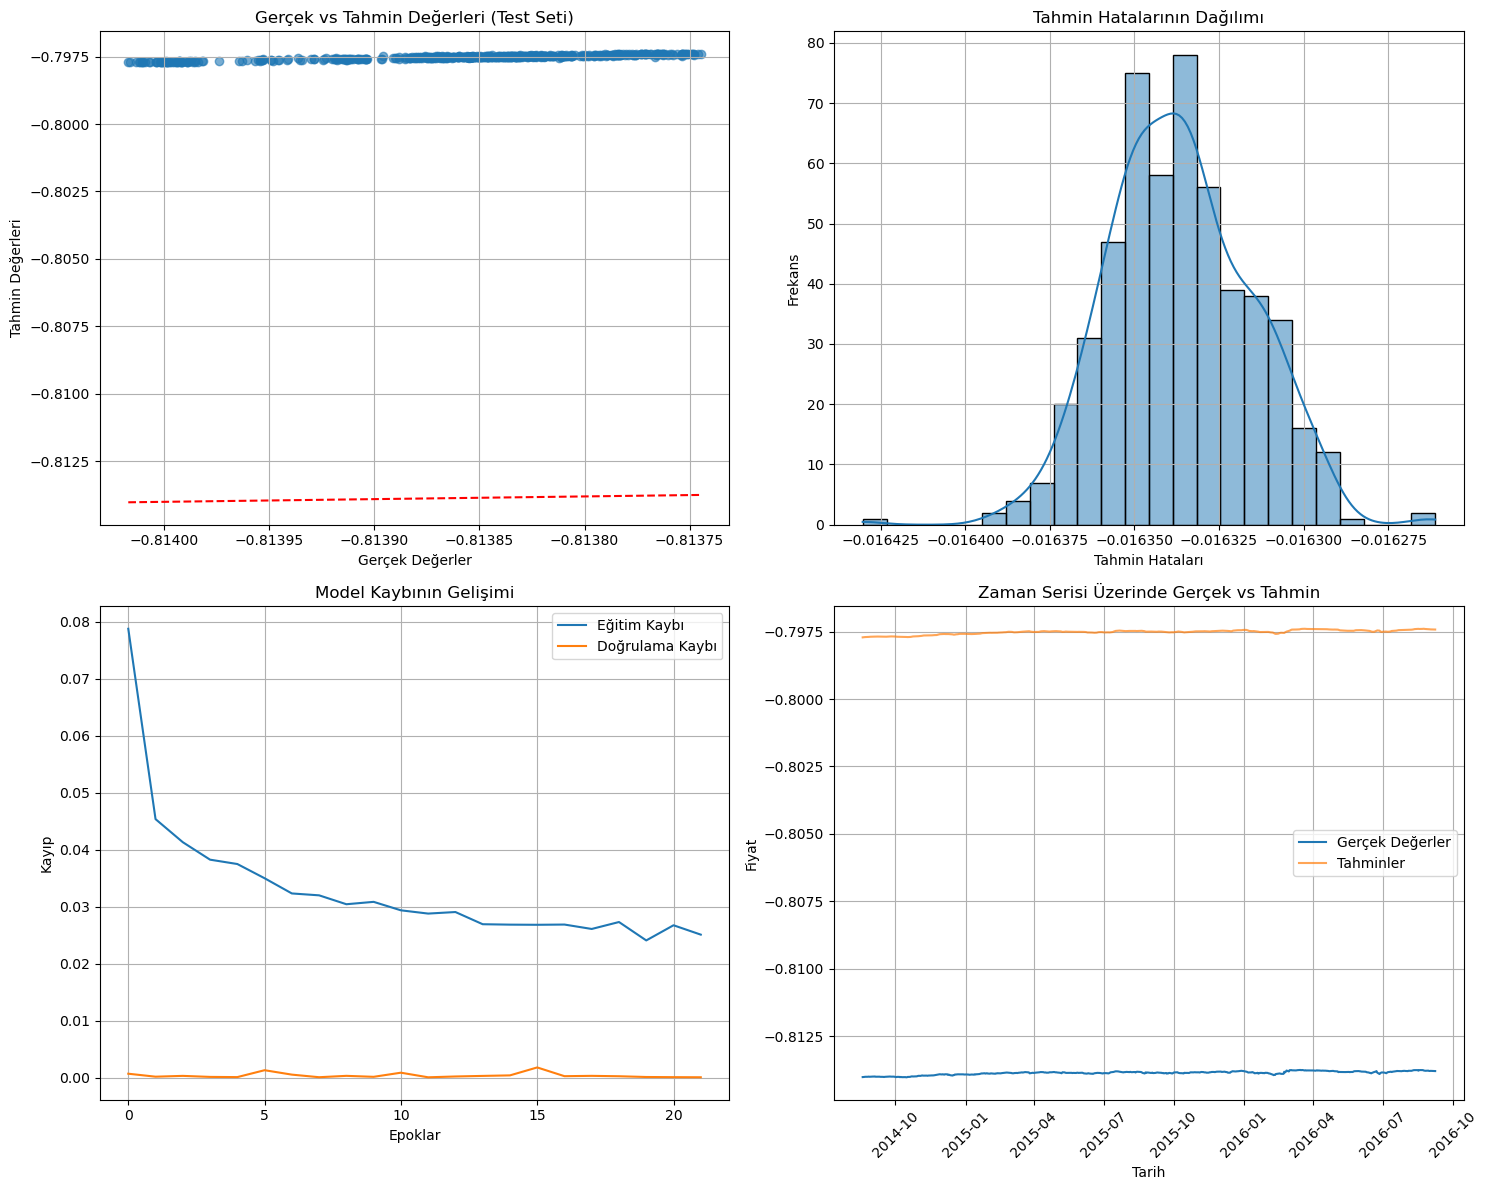

In [13]:
# Grafikleri çizme
plt.figure(figsize=(15, 12))

# Gerçek vs Tahmin scatter plot
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Gerçek vs Tahmin Değerleri (Test Seti)')
plt.grid(True)

# Hata dağılımı histogramı
plt.subplot(2, 2, 2)
errors = y_test_actual.flatten() - test_predict.flatten()
sns.histplot(errors, kde=True)
plt.xlabel('Tahmin Hataları')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı')
plt.grid(True)

# Kayıp eğrisi
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.title('Model Kaybının Gelişimi')
plt.legend()
plt.grid(True)

# Gerçek vs Tahmin zaman serisi
plt.subplot(2, 2, 4)
test_dates = data.index[split_idx + SEQ_LENGTH:]
plt.plot(test_dates, y_test_actual, label='Gerçek Değerler')
plt.plot(test_dates, test_predict, label='Tahminler', alpha=0.7)
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('Zaman Serisi Üzerinde Gerçek vs Tahmin')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()